In [79]:
%load_ext autoreload
%autoreload 2

import os
base_path = '/sdf/home/c/chitturi/neural-representation-sqw/'
os.chdir(base_path)

#from utils import *
from src.utils import * 
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
batch_size = 2048
max_iter = 1000
learning_rate = 0.005
n_repeat = 10
model = tf.keras.models.load_model('surrogate_model')

In [75]:
all_low_count_sqw_path2_woBG = np.load('data_low_count/low_count_data_woBG_path2.npy')
all_low_count_sqw_path3_woBG = np.load('data_low_count/low_count_data_woBG_path3.npy')

all_low_count_sqw_path2 = np.load('data_low_count/low_count_data_path2.npy')
all_low_count_sqw_path3 = np.load('data_low_count/low_count_data_path3.npy')


In [76]:
c_q_path2 = np.array(pd.read_csv('data_experimental/Qlist_path2_woBG.csv', header=None)).T
c_E_path2 = np.array(pd.read_csv('data_experimental/Elist_path2_woBG.csv', header=None)[0]).T

c_q_path3 = np.array(pd.read_csv('data_experimental/Qlist_path3_woBG.csv', header=None)).T
c_E_path3 = np.array(pd.read_csv('data_experimental/Elist_path3_woBG.csv', header=None)[0]).T
    
pred_iter = [] 

for i in tqdm(range(len(all_low_count_sqw_path2))):
    
    # Load data without background -- this is the data that is used for the optimization
    low_count_sqw_path2_woBG = all_low_count_sqw_path2_woBG[i]
    low_count_sqw_path3_woBG = all_low_count_sqw_path3_woBG[i]
    
    # Load data with background -- used to calcualte total number of neutrons across both slices
    low_count_sqw_path2 = all_low_count_sqw_path2[i]
    low_count_sqw_path3 = all_low_count_sqw_path3[i]
    total_neutrons = np.sum(low_count_sqw_path2) + np.sum(low_count_sqw_path3)
    
    # Convert data to coordinate format 
    test_x_path2, test_y_path2 = convert_low_count_data_to_coordinates(c_q_path2, c_E_path2, low_count_sqw_path2_woBG)
    test_x_path3, test_y_path3  =convert_low_count_data_to_coordinates(c_q_path3, c_E_path3, low_count_sqw_path3_woBG)
    
    test_x = tf.convert_to_tensor(np.vstack((test_x_path2, test_x_path3[test_y_path3 != 0])), dtype=tf.float32) # exclude missing slice 
    test_y = tf.convert_to_tensor(np.concatenate((test_y_path2, test_y_path3[test_y_path3 != 0])), dtype=tf.float32)
    
    # Repeat multiple times and return the solution with the minimal loss 
    metrics_n_repeat = []
    for _ in range(n_repeat):
        min_loss, min_loss_j1, min_loss_j2, metrics  = optimize_surrogate(test_x, test_y, model, learning_rate = learning_rate, batch_size = batch_size, max_iter=max_iter, plotting=False)
        metrics_n_repeat.append([min_loss, min_loss_j1, min_loss_j2])
        
    metrics_n_repeat = np.array(metrics_n_repeat)
    lowest_loss_prediction_index = np.argmin(metrics_n_repeat[:,0])    
    lowest_loss_prediction = metrics_n_repeat[lowest_loss_prediction_index]
    
    j1_pred = lowest_loss_prediction[1]
    j2_pred = lowest_loss_prediction[2]
    
    pred_iter.append([total_neutrons, j1_pred, j2_pred])
    
    print(pred_iter[i])
        
pred_iter = np.array(pred_iter)         

  7%|▋         | 1/15 [02:18<32:16, 138.35s/it]

[845.0, 0.2367493361234665, 0.8655226230621338]


 13%|█▎        | 2/15 [04:34<29:41, 137.01s/it]

[1805.0, 0.2354113906621933, 1.326816201210022]


 20%|██        | 3/15 [06:49<27:15, 136.28s/it]

[4419.0, 0.4646444022655487, 0.5471821427345276]


 27%|██▋       | 4/15 [09:06<24:59, 136.34s/it]

[8985.0, -0.33143365383148193, 1.4087321758270264]


 33%|███▎      | 5/15 [11:20<22:35, 135.52s/it]

[13487.0, 0.4474572539329529, 0.0]


 40%|████      | 6/15 [13:37<20:23, 135.93s/it]

[17860.0, 0.472021222114563, 0.0]


 47%|████▋     | 7/15 [15:53<18:09, 136.20s/it]

[20589.0, 0.45425674319267273, 0.0]


 53%|█████▎    | 8/15 [18:09<15:52, 136.12s/it]

[44610.0, 0.3228265941143036, 1.2052994966506958]


 60%|██████    | 9/15 [20:26<13:38, 136.40s/it]

[62729.0, 0.3226010799407959, 1.201602578163147]


 67%|██████▋   | 10/15 [22:48<11:29, 137.98s/it]

[88910.0, 0.32332587242126465, 1.2219913005828857]


 73%|███████▎  | 11/15 [25:04<09:09, 137.34s/it]

[134454.0, 0.32014086842536926, 1.2212204933166504]


 80%|████████  | 12/15 [27:23<06:53, 137.94s/it]

[178918.0, 0.32073792815208435, 1.2180653810501099]


 87%|████████▋ | 13/15 [29:42<04:36, 138.37s/it]

[268493.0, 0.32124871015548706, 1.2126069068908691]


 93%|█████████▎| 14/15 [31:58<02:17, 137.48s/it]

[358787.0, 0.3232400715351105, 1.2224780321121216]


100%|██████████| 15/15 [34:15<00:00, 137.03s/it]

[894506.0, 0.3214414417743683, 1.2244187593460083]


In [77]:
np.save('figures/data_for_figures/low_count_predictions', pred_iter)

In [80]:
pred_iter = np.load('figures/data_for_figures/low_count_predictions.npy')

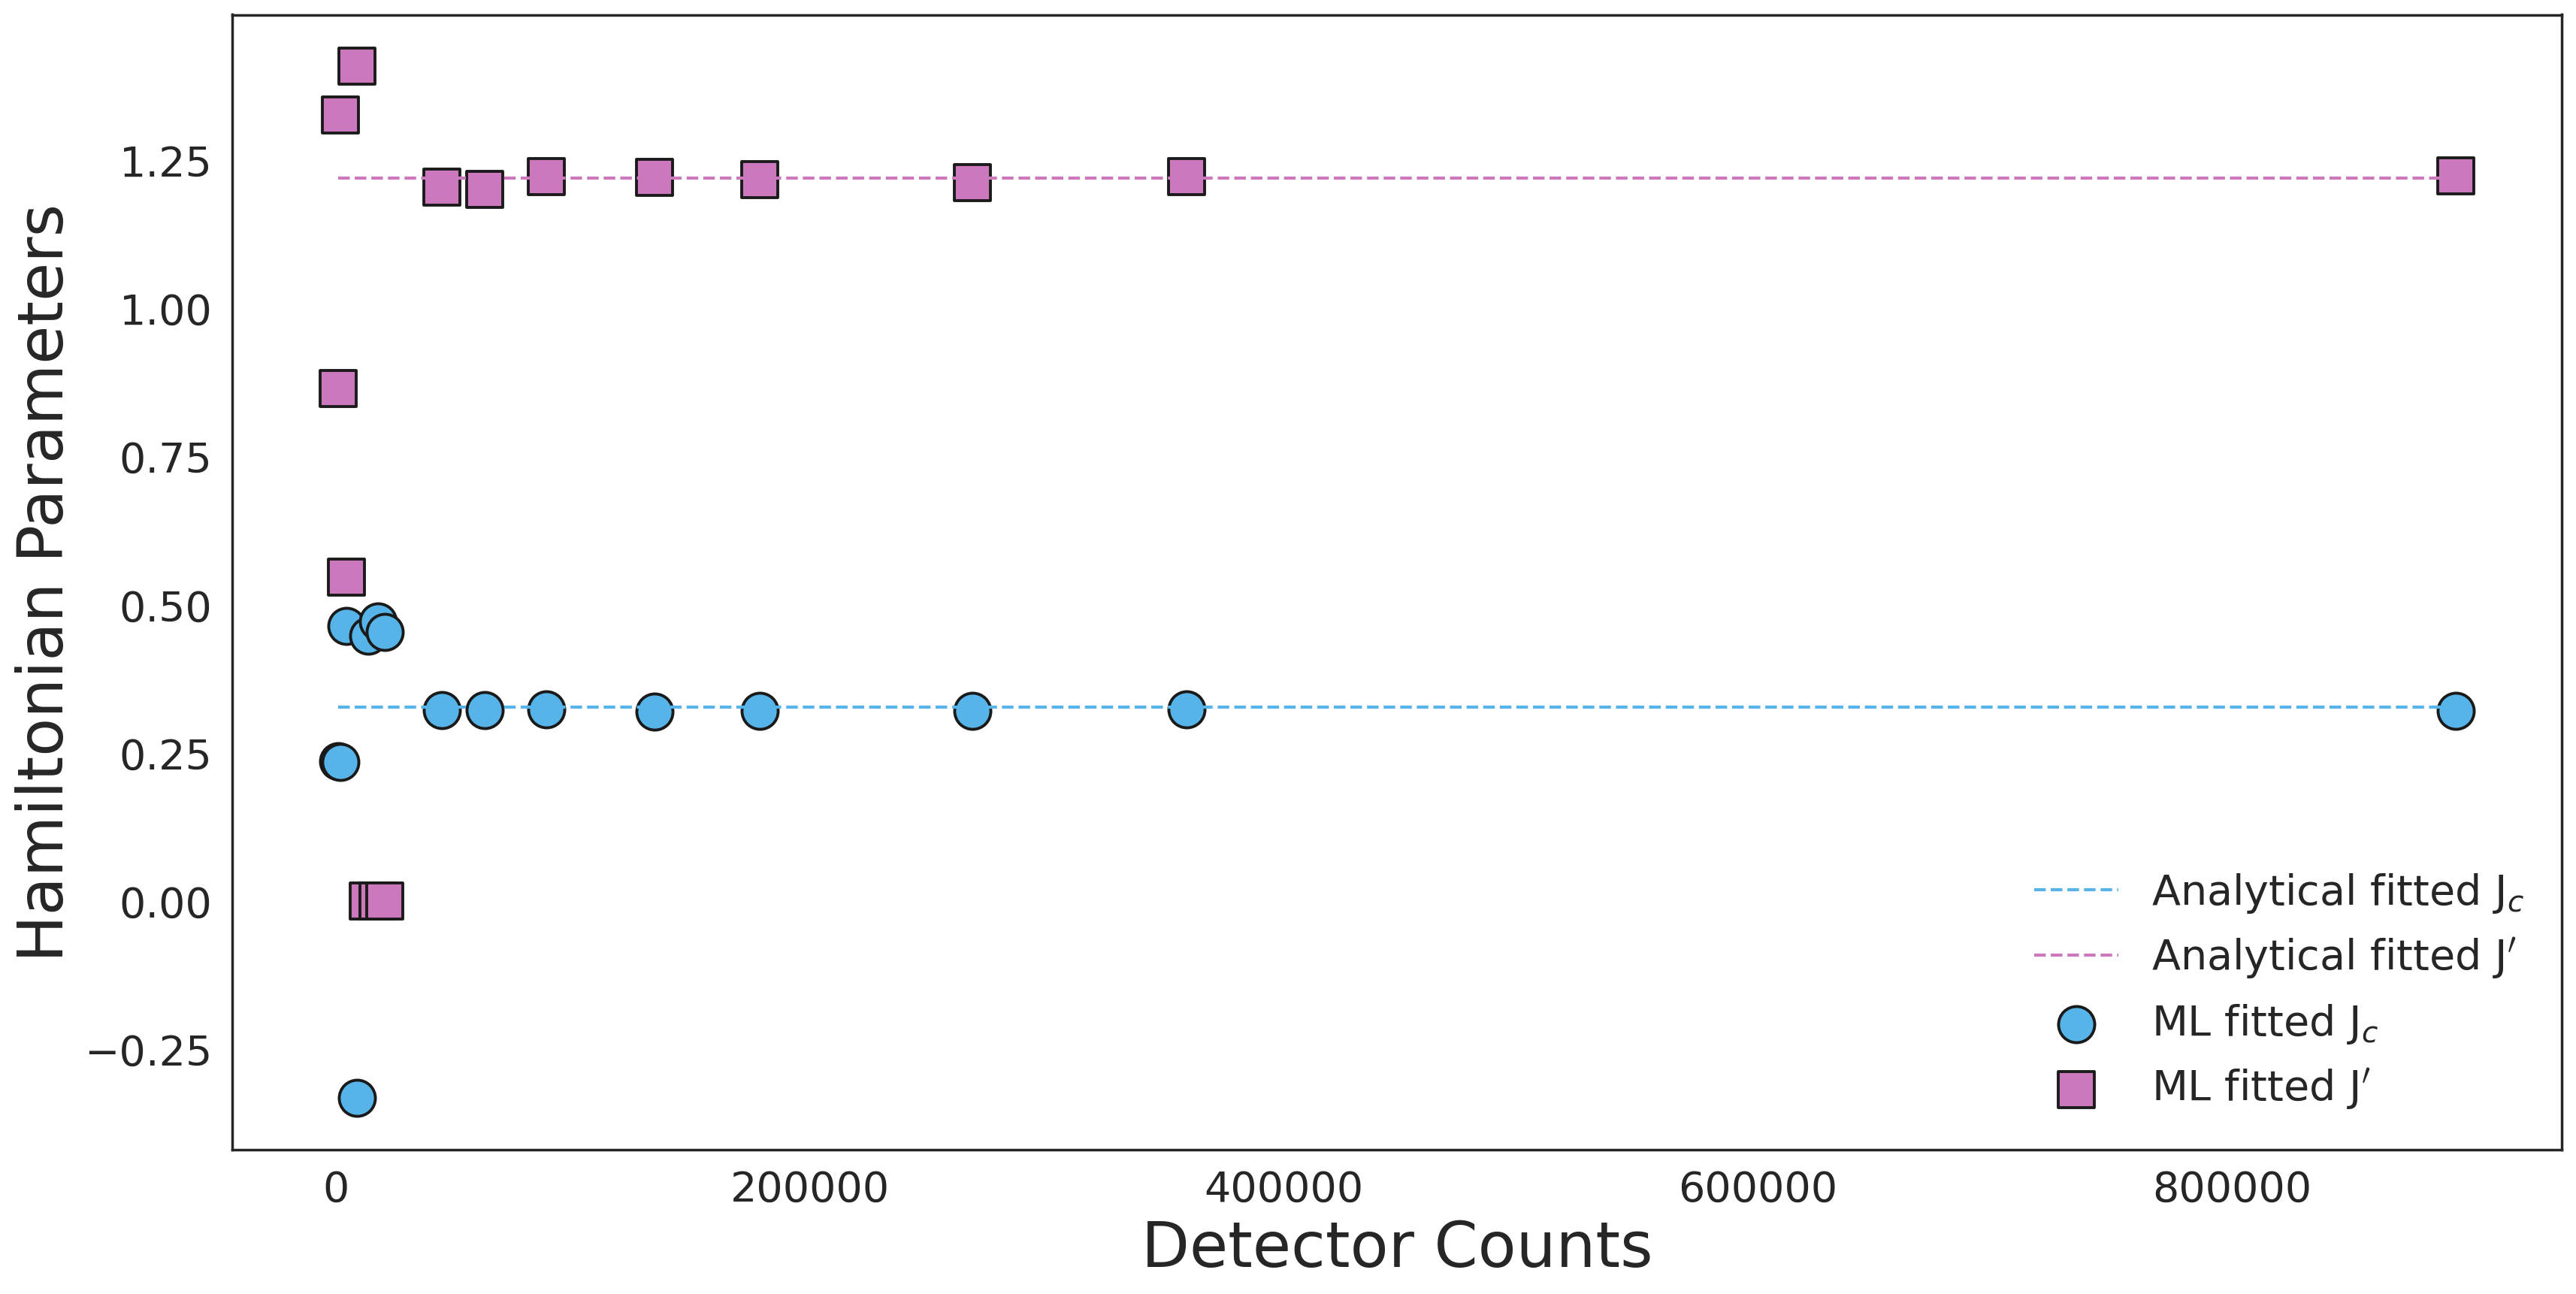

In [81]:
import seaborn as sns
sns.set_theme(style="white")
palette = sns.color_palette("colorblind")

plt.figure(figsize=(20, 10), dpi=200)
c1 = palette[9]
c2 = palette[4]

sns.scatterplot(x=pred_iter[:,0], y=pred_iter[:,1], color=c1, s=300,marker='o', edgecolor='k', label=r'ML fitted J$_c$')
sns.scatterplot(x=pred_iter[:,0], y=pred_iter[:,2], color=c2, s=300, marker='s', edgecolor='k', label = "ML fitted J$'$")
plt.plot(pred_iter[:,0], 0.328*np.ones(pred_iter[:,0].shape), "--", label=r'Analytical fitted J$_c$', color = c1)
plt.plot(pred_iter[:,0], 1.2198*np.ones(pred_iter[:,0].shape), "--", label = "Analytical fitted J$'$",  color = c2)
plt.xlabel('Detector Counts', fontsize = 30)
plt.ylabel('Hamiltonian Parameters', fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg = plt.legend(fontsize=20)
leg.get_frame().set_visible(False) #
plt.show()